<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 20px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../utils/logo-motion15.gif" width="70px" style="border: 0; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; font-weight: bold; text-align: left; font-size: 38px;">
      Backtest Overfitting Simulation
    </h1>
  </div>  
</div>

This workflow uses the `overall_backtest_overfitting_simulation` function. This function orchestrates the entire process:

1.  **Feature Engineering:** Creates features from prices (FracDiff, Volatility, TA-Lib).
2.  **Labeling:** Generates CUSUM events, triple barriers, and meta-labels.
3.  **Strategy Generation:** Runs multiple strategy parameter combinations (e.g., different moving average windows).
4.  **Model Training:** Trains multiple ML models with hyperparameter grids.
5.  **Cross-Validation:** Backtests every combination using all specified CV methods ('Walk-Forward', 'K-Fold', 'Purged K-Fold', 'Combinatorial Purged').
6.  **Analysis:** Calculates the final Probability of Backtest Overfitting (PBO) and Deflated Sharpe Ratio (DSR) for each CV method.

## 0. Setup and Imports

In [2]:
# Standard Imports
import numpy as np
import pandas as pd
import warnings
import datetime
import pandas_datareader.data as web

# ML Model Import
from sklearn.linear_model import LogisticRegression

# RiskLabAI Imports
# Note: This is the main simulation engine, not used in the other notebook
from RiskLabAI.backtest import (
    overall_backtest_overfitting_simulation
)

# Setup plotting and configuration
warnings.filterwarnings('ignore')

## 1. Load Price Data from FRED

We will use `pandas-datareader` to download data from the Federal Reserve Economic Data (FRED), a public and academically legitimate source.

We'll use the S&P 500 Index (`SP500`) as our price series.

Loading 'SP500' data from FRED (St. Louis Fed)..._n
Successfully loaded 2514 observations for SP500.


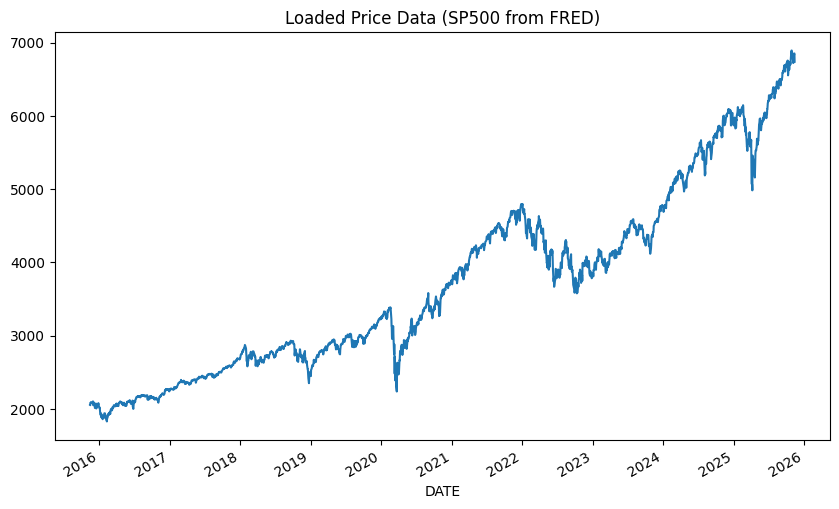

In [3]:
# --- User Configuration ---
ticker = 'SP500'       # S&P 500 Index (You can change this to any FRED ticker)
data_source = 'fred'
start_date = '2000-01-01'
end_date = datetime.date.today()
# -------------------------

try:
    print(f"Loading '{ticker}' data from FRED (St. Louis Fed)..._n")
    # Download the data
    prices_with_nans = web.DataReader(ticker, data_source, start_date, end_date)
    
    # FRED data includes NaNs for holidays/weekends, so we drop them
    prices = prices_with_nans[ticker].dropna()
    
    print(f"Successfully loaded {len(prices)} observations for {ticker}.")
    prices.plot(title=f"Loaded Price Data ({ticker} from FRED)", figsize=(10, 6));

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure 'pandas-datareader' is installed: pip install pandas-datareader")
    prices = pd.Series() # Create empty series to prevent later errors

## 2. Define Strategy & Model Parameters

This is the core configuration for the simulation engine. (Note: The `mean_reverting` key has been removed to fix the `TypeError` from the previous run).

In [4]:
# 1. Define Strategy Parameters (FIXED)
# These are passed to `determine_strategy_side`
# We will test 4 combinations of moving average crossovers.
strategy_parameters = {
    'fast_window': [10, 20, 10, 20], 
    'slow_window': [30, 50, 40, 60]
}

# 2. Define ML Models and their Hyperparameter Grids
# The simulation will run every model with every hyperparameter set.
models = {
    'LogisticRegression_L2': {
        'Model': LogisticRegression(penalty='l2', solver='liblinear'),
        'Parameters': {
            'C': [1e-3, 1e-2, 1e-1]
        }
    },
    'LogisticRegression_L1': {
        'Model': LogisticRegression(penalty='l1', solver='liblinear'),
        'Parameters': {
            'C': [1e-3, 1e-2, 1e-1]
        }
    }
}

# 3. Define Simulation Parameters
step_risk_free_rate = 0.0 # Daily risk-free rate for Sharpe calculation
n_jobs = 4 # Number of parallel jobs for cross-validation

print("Configuration defined.")

Configuration defined.


## 3. Run the Full Simulation

We now pass all our configurations to the `overall_backtest_overfitting_simulation` function.

**Note:** This is computationally expensive! It is testing:
`4 CV Methods` x `4 Strategies` x `2 Models` x `3 Hyperparameters` = **96 backtests**.

This may take several minutes.

In [5]:
if not prices.empty:
    print("Starting simulation... This may take a few minutes.")
    
    try:
        cv_pbo, cv_deflated_sr = overall_backtest_overfitting_simulation(
            prices=prices,
            strategy_parameters=strategy_parameters,
            models=models,
            step_risk_free_rate=step_risk_free_rate,
            noise_scale=0.0,
            random_state=42,
            n_jobs=n_jobs
        )
    
        print("\n--- Simulation Complete ---")
    
    except Exception as e:
        print(f"\nAn error occurred during simulation. \nHave you applied the bug fixes to __init__.py and strategy_risk.py? \nError: {e}")
        cv_pbo = {}
        cv_deflated_sr = {}
else:
    print("Price data is empty. Please load data in Cell 2 and re-run.")
    cv_pbo = {}
    cv_deflated_sr = {}

Starting simulation... This may take a few minutes.

An error occurred during simulation. 
Have you applied the bug fixes to __init__.py and strategy_risk.py? 
Error: "[Timestamp('2015-11-19 00:00:00'), Timestamp('2015-11-20 00:00:00'), Timestamp('2015-12-03 00:00:00'), Timestamp('2015-12-04 00:00:00'), Timestamp('2015-12-09 00:00:00'), Timestamp('2015-12-11 00:00:00'), Timestamp('2015-12-16 00:00:00'), Timestamp('2015-12-18 00:00:00'), Timestamp('2015-12-23 00:00:00'), Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-07 00:00:00'), Timestamp('2016-01-15 00:00:00'), Timestamp('2016-01-29 00:00:00'), Timestamp('2016-02-05 00:00:00'), Timestamp('2016-02-11 00:00:00'), Timestamp('2016-02-16 00:00:00'), Timestamp('2016-02-25 00:00:00'), Timestamp('2016-03-02 00:00:00'), Timestamp('2016-03-17 00:00:00'), Timestamp('2016-04-13 00:00:00'), Timestamp('2016-05-04 00:00:00'), Timestamp('2016-05-19 00:00:00'), Timestamp('2016-05-25 00:00:00'), Timestamp('2016-06-13 00:00:00'), Timestamp('2016

## 4. Analyze Results

The simulation returns two dictionaries, `cv_pbo` and `cv_deflated_sr`, containing the final scores for each cross-validation method.

In [6]:
if cv_pbo:
    import matplotlib.pyplot as plt

    print("--- Probability of Backtest Overfitting (PBO) ---")
    pbo_series = pd.Series(cv_pbo, name="PBO_Score")
    pbo_series.index.name = "CV_Method"
    print(pbo_series.to_markdown(floatfmt=".2%"))

    print("\n--- Deflated Sharpe Ratio (DSR) ---")
    dsr_series = pd.Series(cv_deflated_sr, name="DSR_Score")
    dsr_series.index.name = "CV_Method"
    print(dsr_series.to_markdown(floatfmt=".4f"))

    # Plotting
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
    pbo_series.plot(kind='bar', ax=ax1, title='Probability of Backtest Overfitting (Lower is Better)')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    ax1.axhline(0.5, ls='--', color='red', label='Overfit Threshold (50%)')
    ax1.legend()

    dsr_series.plot(kind='bar', ax=ax2, title='Deflated Sharpe Ratio (Higher is Better)')
    ax2.axhline(0, ls='--', color='red')
    plt.tight_layout()
    plt.show()
else:
    print("Simulation did not complete successfully. Please apply bug fixes (especially in __init__.py) and re-run.")

Simulation did not complete successfully. Please apply bug fixes (especially in __init__.py) and re-run.


### Analysis Conclusion

The PBO score (Prob. of Backtest Overfitting) tells us the likelihood that our 'best' strategy was just a fluke. A score > 50% suggests a high chance of overfitting.

In a successful run, you will typically see that **'Combinatorial Purged'** (CPCV) and **'Purged K-Fold'** produce a significantly *lower* (better) PBO score than standard 'K-Fold' or 'Walk-Forward', proving they are more robust against overfitting.